In [1]:
# Standard Library Imports
import os
import pandas as pd
import sys

# Third-Party Imports
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Local Module Imports
sys.path.append('../src/complete_collision_recorder/')
import complete_collision as cc
import utils as u


# Map project directories
root_dir, src_dir, data_dir, models_dir = u.map_project_directories(notebook=True)

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_df = pd.read_csv(os.path.join(data_dir, "processed", "training_df.csv"))
training_df['concatenated_text'] = training_df.apply(u.concatenate_texts, axis=1)

In [3]:
# Load the severity model
with open(os.path.join(models_dir,'severity.pkl'), 'rb') as f:
    severity_best = pickle.load(f)

In [4]:
training_df['SEVERITY_PRED'] = severity_best.predict(training_df['concatenated_text'])
training_df['SEVERITY_PRED'].value_counts()

SEVERITY_PRED
0    1923
1     252
Name: count, dtype: int64

In [5]:
GCAT_pred_df = training_df.copy()
GCAT_pred_df['SEVERITY_PRED_TEXT'] = GCAT_pred_df['SEVERITY_PRED'].replace({
    0: '',
    1: 'SEVERE INJURY',
})
GCAT_pred_df['GCAT_PRED_TEXT'] = GCAT_pred_df['SEVERITY_PRED_TEXT'] # + ' ' + GCAT_pred_df['TURN_PRED_TEXT']
GCAT_pred_df['GCAT_PRED_TEXT'] = GCAT_pred_df['GCAT_PRED_TEXT'].apply(lambda x: 'NONE' if x.strip() == '' else x)
GCAT_pred_df['concatenated_text'] = GCAT_pred_df['concatenated_text'] + '\n\n GCAT INDICATORS: ' + GCAT_pred_df['GCAT_PRED_TEXT']

In [6]:
# len(GCAT_pred_df)
narrative_testing_df = GCAT_pred_df[GCAT_pred_df['BIKE_CLE_TEXT'].notna() ].sample(100, random_state=123)
narrative_training_df = GCAT_pred_df[GCAT_pred_df['BIKE_CLE_TEXT'].notna() ].drop(narrative_testing_df.index)
print(f"Number of records with input text: {len(GCAT_pred_df)}")
print(f"Number of records with input text but no label text: {len(GCAT_pred_df) - len(GCAT_pred_df[GCAT_pred_df['BIKE_CLE_TEXT'].notna()])}")
print(f"Number of records with both input text and label text: {len(GCAT_pred_df[GCAT_pred_df['BIKE_CLE_TEXT'].notna()])}")
print(f"Number of randomly selected testing pairs: {len(narrative_testing_df)}")
print(f"Number of training pairs: {len(narrative_training_df)}")

Number of records with input text: 2175
Number of records with input text but no label text: 859
Number of records with both input text and label text: 1316
Number of randomly selected testing pairs: 100
Number of training pairs: 1216


In [7]:
narrative_testing_df[['concatenated_text','BIKE_CLE_TEXT']].to_csv(os.path.join(data_dir, "processed", "narrative_testing_df.csv"), index=False)
narrative_training_df[['concatenated_text','BIKE_CLE_TEXT']].to_csv(os.path.join(data_dir, "processed", "narrative_training_df.csv"), index=False)
print("Saved testing and training dataframes to data/processed/narrative_testing_df.csv and data/processed/narrative_training_df.csv")

Saved testing and training dataframes to data/processed/narrative_testing_df.csv and data/processed/narrative_training_df.csv


## MANUAL INSTRUCTION: Upload and run Fine-Tuning of Gemini 1.5 in Google's AI Studio - See screenshots below

Google's AI Studio for Fine-Tuning Text: https://aistudio.google.com/tune

Link to the model training in this project: https://aistudio.google.com/tunedModels/narrativetrainingdf-oo49g0etpnrj

Be sure to generate an API Key and add it to the .env file in the root directory of the project

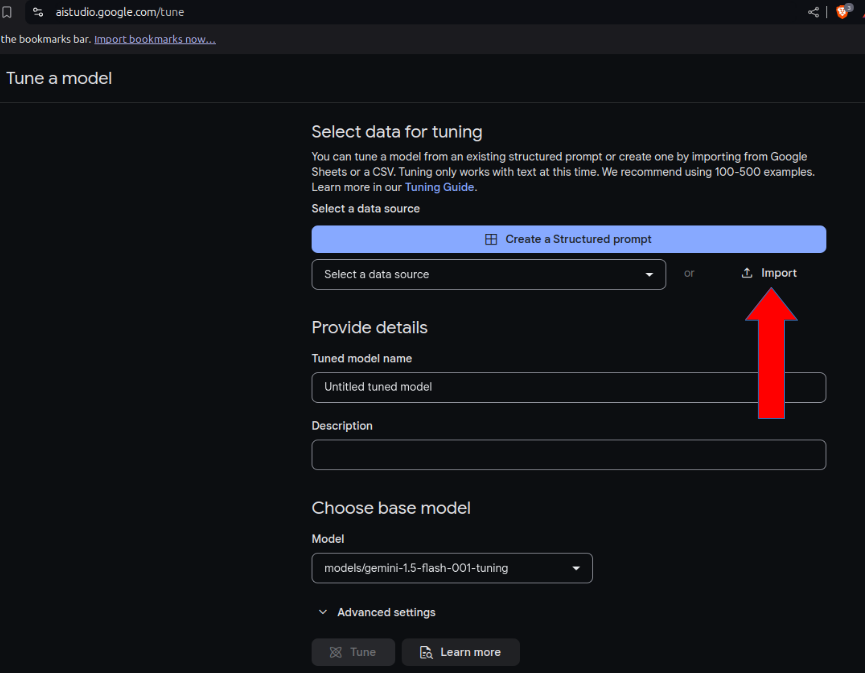

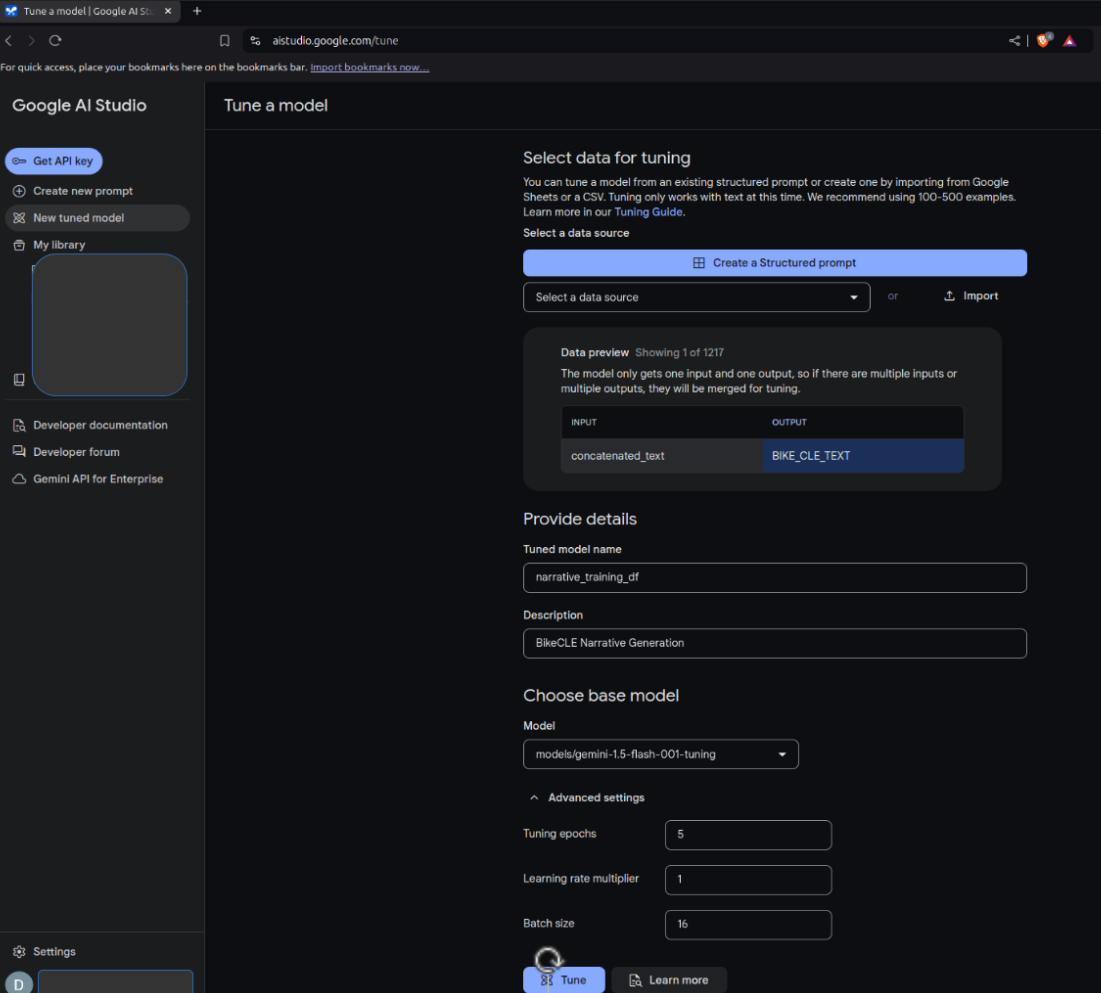

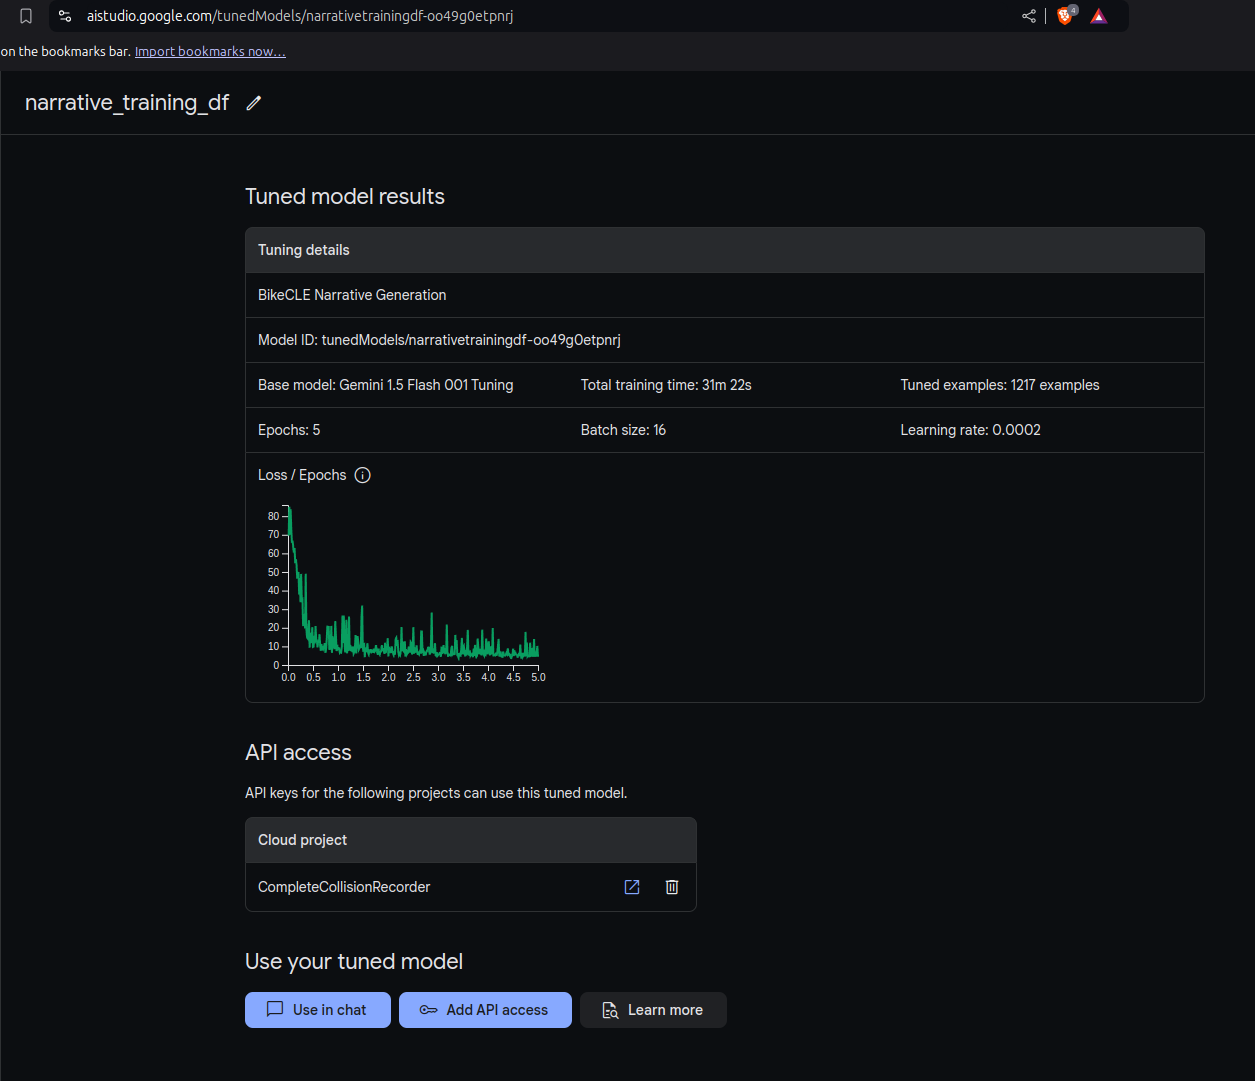

In [39]:
load_data_image_path = os.path.join(models_dir, 'Gemini_load_data.png')
display(Image(filename=load_data_image_path))
define_input_output_image_path = os.path.join(models_dir, 'Gemini_define_input_and_output_fields.png')
display(Image(filename=define_input_output_image_path))
image_path = os.path.join(models_dir, 'BikeCLE_narrative_fine_tune_training_results.png')
display(Image(filename=image_path))

In [9]:
# Score the testing data with the fine-tuned model with Google API
GeminiBikeCleModel = cc.GenBikeCleNarrative(google_api_key="CCR_API")
narrative_testing_df["GenAISummary"] = narrative_testing_df["concatenated_text"].apply(
    lambda x: GeminiBikeCleModel.summarize(
        concat_text=x,
        model_name="tunedModels/narrativetrainingdf-oo49g0etpnrj",
    )
)

In [19]:
# Define the severe injury indicator
keywords = ['severe', 'severely', 'serious', 'killed', 'fatal', 'fatally']
narrative_testing_df['SevereAiReviewInd'] = narrative_testing_df['GenAISummary'].apply(
    lambda x: 1 if any(keyword in x.lower() for keyword in keywords) else 0
)

In [23]:
# Output the testing data for human validation
narrative_testing_df[['concatenated_text', 'BIKE_CLE_TEXT', 'GenAISummary', 'SevereAiReviewInd']].to_csv(os.path.join(data_dir, "processed", "narrative_testing_output_df.csv"), index=False)

## MANUAL INSTRUCTION: 

1) Open narrative_testing_output_df.csv in Excel, or workbook

2) Manually review the quality of generated narratives and enter a 1 for acceptable narrative or 0 for unacceptable in a new field 'NarrativeMatchInd'

3) Manually review and enter a 1 for severe or fatal injury described in text and labels or 0 for no severe injury in a new field 'SevereHumanReviewInd'

4) Save the manually reviewed file as 'narrative_testing_output_reviewed.csv

In [26]:
# Import and show the reviewed data
narrative_testing_reviewed_df = pd.read_csv(os.path.join(data_dir, "processed", "narrative_testing_output_reviewed.csv"))
narrative_testing_reviewed_df.head()

,concatenated_text,BIKE_CLE_TEXT,GenAISummary,NarrativeMatchInd,SevereHumanReviewInd,SevereAiReviewInd
0,CALL COMMENTS COMMENTS FROM INTERGAPH PER EMS ...,A driver struck an adult. The crash caused inj...,A driver struck an adult. The crash caused inj...,1,0,0
1,CALL COMMENTS COMMENTS FROM INTERGAPH LOI SEAR...,A driver of a transit bus struck an adult in t...,The text describes an incident where a driver ...,0,1,0
2,CALL COMMENTS COMMENTS FROM REDACTED SEARCH CO...,A driver of a bus struck a person.,A driver of a transit bus struck a person. The...,1,0,0
3,CALL COMMENTS COMMENTS FROM REDACTED SEARCH CO...,A driver of a passenger car struck an adult on...,This report describes a hit-and-run crash invo...,1,0,0
4,CALL COMMENTS COMMENTS FROM REDACTED SEARCH CO...,A driver struck a person on a bicycle. First r...,A driver struck a person on a bicycle.,1,0,0


In [30]:
# Calculate the accuracy percentage of the GenAI narratives
total_narratives = len(narrative_testing_reviewed_df)
total_narrative_match = narrative_testing_reviewed_df['NarrativeMatchInd'].sum()
accuracy_percent = (total_narrative_match / total_narratives) * 100
print(f"Accuracy Percent of GenAI Narratives: {accuracy_percent:.2f}%")

Accuracy Percent of GenAI Narratives: 92.00%


              precision    recall  f1-score   support

           0       0.99      0.96      0.97        94
           1       0.56      0.83      0.67         6

    accuracy                           0.95       100
   macro avg       0.77      0.90      0.82       100
weighted avg       0.96      0.95      0.95       100



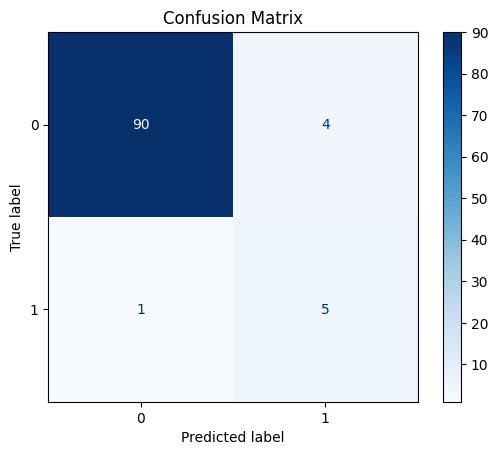

In [36]:
# Calculate the F1 score, precision, and recall of the severe injury indicator
print(classification_report(narrative_testing_reviewed_df['SevereHumanReviewInd'], narrative_testing_reviewed_df['SevereAiReviewInd']))
conf_matrix = confusion_matrix(narrative_testing_reviewed_df['SevereHumanReviewInd'], narrative_testing_reviewed_df['SevereAiReviewInd'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()